# EDA Case Study
***

### Prerequisite

1. Place 'loan.csv' input file at your current working directory before running this code.

2. Please make sure that you have following python libraries imported/installed at your system:

    * numpy version	: 1.12.1 or higher
    * pandas version	: 0.20.3 or higher
    * seaborn version	: 0.8.0 or higher

### Import Libraries and set required parameters

In [1]:
import numpy as np
print('numpy version\t:',np.__version__)
import pandas as pd
print('pandas version\t:',pd.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Regular expressions
import re

# seaborn : advanced visualization
import seaborn as sns
print('seaborn version\t:',sns.__version__)

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.2f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) # to display all the columns

np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

numpy version	: 1.12.1
pandas version	: 0.20.3
seaborn version	: 0.8.0


## Data Sourcing

In [2]:
loan = pd.read_csv('./loan.csv',dtype='object')
print(loan.shape)

(39717, 111)


#### Get some insights

In [3]:
loan.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,...,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0,0,5863.155187,5833.84,5000,863.16,0,0,0,Jan-15,171.62,NaN,May-16,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN


__List of Columns & NA counts where NA values are more than 30%__

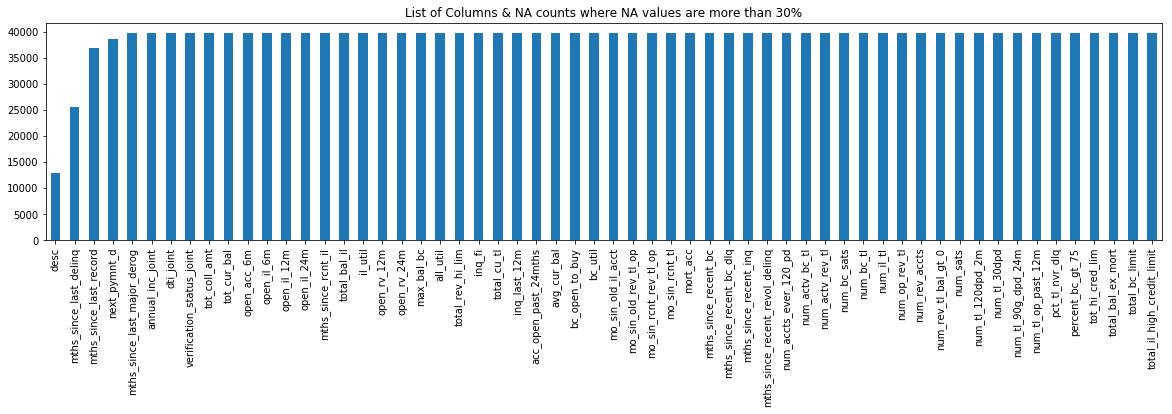

In [4]:
NA_col = loan.isnull().sum()
NA_col = NA_col[NA_col.values >(0.3*len(loan))]
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('List of Columns & NA counts where NA values are more than 30%')
plt.show()

<font color='blue'><b>Insights</b>: So we can see from the above plot that there are 50+ columns in the dataset where all the values are NA.</font> 

As we can see there are <b>39717</b> rows & <b>111</b> columns in the dataset, it will be very difficult to look at each column one by one & find the NA or missing values.
So let's find out all columns where missing values are more than certain percentage, let's say <b>30%</b>. We will remove those columns as it is not feasable to impute missing values for those columns.

We will create a UDF for this.

***
## Data Cleaning

__<font color='green'>UDF :: removeNulls(dataframe, axis, percent)</font>__

###### removeNulls(dataframe, axis, percent) will drop the columns/rows from the dataset based on the parameter values.

In [5]:
def removeNulls(dataframe, axis =1, percent=0.3):
    '''
    * removeNull function will remove the rows and columns based on parameters provided.
    * dataframe : Name of the dataframe  
    * axis      : axis = 0 defines drop rows, axis =1(default) defines drop columns    
    * percent   : percent of data where column/rows values are null,default is 0.3(30%)
              
    '''
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

#### 1. Remove columns where NA values are more than or equal to 30%

In [6]:
loan = removeNulls(loan, axis =1,percent = 0.3)

Number of Columns dropped	:  58

Old dataset rows,columns (39717, 111) 
New dataset rows,columns (39717, 53)


#### 2. Remove rows where NA values are more than or equal to 30%
(Note: NA columns has already been removed in step 1, so we may not find any <b>rows</b> where 30% values are NA)

In [7]:
loan1 = removeNulls(loan, axis =0,percent = 0.3)


Number of Rows dropped	:  0

Old dataset rows,columns (39717, 53) 
New dataset rows,columns (39717, 53)


There are no rows where NA values are more than or equal to 30%

#### 3. Remove columns where number of unique value is only 1.

Let's look at no of unique values for each column.We will remove all columns where number of unique value is only 1 because that will not make any sense in the analysis

In [8]:
unique = loan.nunique()
unique = unique[unique.values == 1]

In [9]:
loan.drop(labels = list(unique.index), axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (39717, 44) rows & columns.


#### 4. Employment Term : Remove 'n/a' value with 0.

There are some values in emp_term which are <b>'n/a'</b>, we assume that are <b>'self-employed'</b>. As we want to keep this column numeric,
replace the 'n/a' value with 0.

In [10]:
print(loan.emp_length.unique())
loan.emp_length.fillna('0',inplace=True)
loan.emp_length.replace(['n/a'],'0',inplace=True)
print(loan.emp_length.unique())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' 'n/a']
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' '0']


#### 5. Remove irrelevant columns.

Till now we have removed the columns based on the count & statistics.
Now let's look at each column from business perspective if that is required or not for our analysis such as Unique ID's, URL.
As last 2 digits of zip code is masked 'xx', we can remove that as well.

In [11]:
not_required_columns = ["id","member_id","url","zip_code"]
loan.drop(labels = not_required_columns, axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (39717, 40) rows & columns.


#### 6. Remove Special characters from numeric columns

Remove all the special characters (except '.') such as '%','<','>' etc. & alphabets such as 'years', 'months' etc from following numeric columns :
'int_rate','term','emp_length'

In [12]:
reg = '[^\.0-9]'

loan['emp_length'] = loan.emp_length.str.replace(pat = reg,repl='')
loan['term'] = loan.term.str.replace(pat = reg,repl='')
loan['int_rate'] = loan.int_rate.str.replace(pat = reg,repl='')

#### 7. Cast all continuos variables to numeric
Cast all continuos variables to numeric so that we can find a correlation between them

In [13]:
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','term','int_rate','emp_length','annual_inc','dti']

loan[numeric_columns] = loan[numeric_columns].apply(pd.to_numeric)
#loan[numeric_columns] = loan[numeric_columns].apply(lambda x: x.astype(int))

In [14]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975.00,36,10.65,162.87,B,B2,NaN,10,RENT,24000.00,Verified,Dec-11,Fully Paid,credit_card,Computer,AZ,27.65,0,Jan-85,1,3,0,13648,83.70%,9,0,0,5863.155187,5833.84,5000,863.16,0,0,0,Jan-15,171.62,May-16,0
1,2500,2500,2500.00,60,15.27,59.83,C,C4,Ryder,1,RENT,30000.00,Source Verified,Dec-11,Charged Off,car,bike,GA,1.00,0,Apr-99,5,3,0,1687,9.40%,4,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,Apr-13,119.66,Sep-13,0
2,2400,2400,2400.00,36,15.96,84.33,C,C5,NaN,10,RENT,12252.00,Not Verified,Dec-11,Fully Paid,small_business,real estate business,IL,8.72,0,Nov-01,2,2,0,2956,98.50%,10,0,0,3005.666844,3005.67,2400,605.67,0,0,0,Jun-14,649.91,May-16,0
3,10000,10000,10000.00,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,RENT,49200.00,Source Verified,Dec-11,Fully Paid,other,personel,CA,20.00,0,Feb-96,1,10,0,5598,21%,37,0,0,12231.89,12231.89,10000,2214.92,16.97,0,0,Jan-15,357.48,Apr-16,0
4,3000,3000,3000.00,60,12.69,67.79,B,B5,University Medical Group,1,RENT,80000.00,Source Verified,Dec-11,Current,other,Personal,OR,17.94,0,Jan-96,0,15,0,27783,53.90%,38,524.06,524.06,3513.33,3513.33,2475.94,1037.39,0,0,0,May-16,67.79,May-16,0


***
## Data & Business Understanding

#### 1. Remove Customer Behaviour(Customer Loan transactions) data

If you look at the metadata, you will find three types of variables: 
    * variables related to customer information -> customer_info
    * variables related to the loan details -> loan_info
    * variables related to the customers behaviour details (post loan) -> customer_behaviour

In [15]:
customer_info = ['emp_title','emp_length','home_ownership','annual_inc','verification_status','title','addr_state']

loan_info = ['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','grade','sub_grade','issue_d',\
             'loan_status','dti','purpose']

customer_behaviour = ['delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util',\
                      'total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',\
                      'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',\
                      'last_pymnt_d','last_pymnt_amnt','last_credit_pull_d','pub_rec_bankruptcies']

*Now,think of mapping business problem with the dataset.You could find that the variables related to the customer
behaviour data can't be collected at the time of applicantion. Thus analysing these variable could not solve 
our business problem. In general,our company wants to understand the driving
factors behind the loan default at the time of application stage.So features related to Customer Behaviour are redundant w.r.t this case study. *

So, going forward, we will do the analysis on the remaining two types of variables:

1. Variables related to customers demographic and its characteristics
2. Variables related to the loan characteristics

So before start analysing the case study,we will <b>remove the customer_behaviour variables</b> from the analysis.

In [16]:
loan.drop(labels = customer_behaviour, axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (39717, 19) rows & columns.


#### 2. Loan Status : Drop records where Loan Status is in-progress

In [17]:
loan.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

There are 3 types of Loan status, we can <b>filter</b> out the Loan records which are currently <b>in progress</b> because we don't know weather the in-progress loan holder will charge-off or not.

In [18]:
loan.drop(labels = loan[loan['loan_status']=='Current'].index, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (38577, 19) rows & columns.


#### 3. Purpose of loan : Drop records where values are less than 1.5%
We will analyse only those categories which contain more than 1.5% of records.
Also, we are not aware what comes under 'Other' we will remove this category as well.

In [19]:
del_loan_purpose = (loan.purpose.value_counts()*100)/len(loan)
del_loan_purpose = del_loan_purpose[(del_loan_purpose < 1.5) | (del_loan_purpose.index == 'other')]
del_loan_purpose

other              10.02
moving              1.49
vacation            0.97
house               0.95
educational         0.84
renewable_energy    0.26
Name: purpose, dtype: float64

In [20]:
loan.drop(labels = loan[loan.purpose.isin(del_loan_purpose.index)].index, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (32967, 19) rows & columns.


***
## Derived Metrics

** We will now derive some new columns based on our business understanding that will be helpful in our analysis. **

#### 1. Loan amount to Annual Income ratio

In [21]:
loan['loan_income_ratio']= loan['loan_amnt']/loan['annual_inc']

#### 2. Extract Year from Issue date

In [22]:
loan['issue_year'] = loan['issue_d'].apply(lambda x: '20'+x[4:6])

#### 3. Extract Month from Issue date

In [23]:
loan['issue_month'] =loan['issue_d'].apply(lambda x:x[0:3])
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
loan['issue_month'] = pd.Categorical(loan['issue_month'],categories=months_order, ordered=True)

#### 4. Create Bins for range of Loan Amount

In [24]:
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
loan['loan_amnt_range'] = pd.cut(loan['loan_amnt'], bins, labels=slot)

#### 5. Create Bins for range of Annual Income

In [25]:
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
loan['annual_inc_range'] = pd.cut(loan['annual_inc'], bins, labels=slot)

#### 6. Create Bins for range of Interest rates

In [26]:
bins = [0, 7.5, 10, 12.5, 15,20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
loan['int_rate_range'] = pd.cut(loan['int_rate'], bins, labels=slot)

***
## Univariate Analysis

### Continuous Variables
In case of continuous variables, we need to understand the central tendency and spread of the variable.These are measured using various statistical metrics visualization methods such as Boxplot,Histogram/Distribution Plot, Violin Plot etc.

### Categorical Variables

For categorical variables, we’ll use frequency table to understand distribution of each category. It can be be measured using two metrics, Count and Count% against each category. Countplot or Bar chart can be used as visualization.

__<font color='green'>UDF :: univariate(df,col,vartype,hue)</font>__

###### Univariate function will plot the graphs based on the parameter values.

In [27]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        if width >15:
            dodge = False
            w=0.32 
        else: 
            dodge = True
            w=0.12
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,dodge=dodge) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+w, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

### Continuous Variables

#### 1. Loan Amount

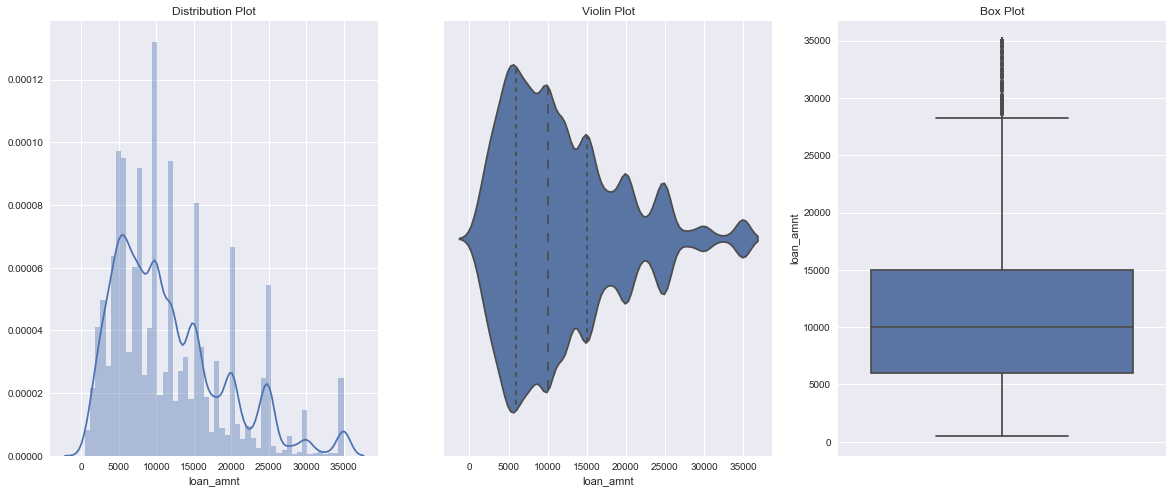

In [28]:
univariate(df=loan,col='loan_amnt',vartype=0)

<font color='blue'><b>Insights</b>: Most of the loan amounts are distributed between 5000 to 15000 USD.</font> 

#### 2. Interest Rate

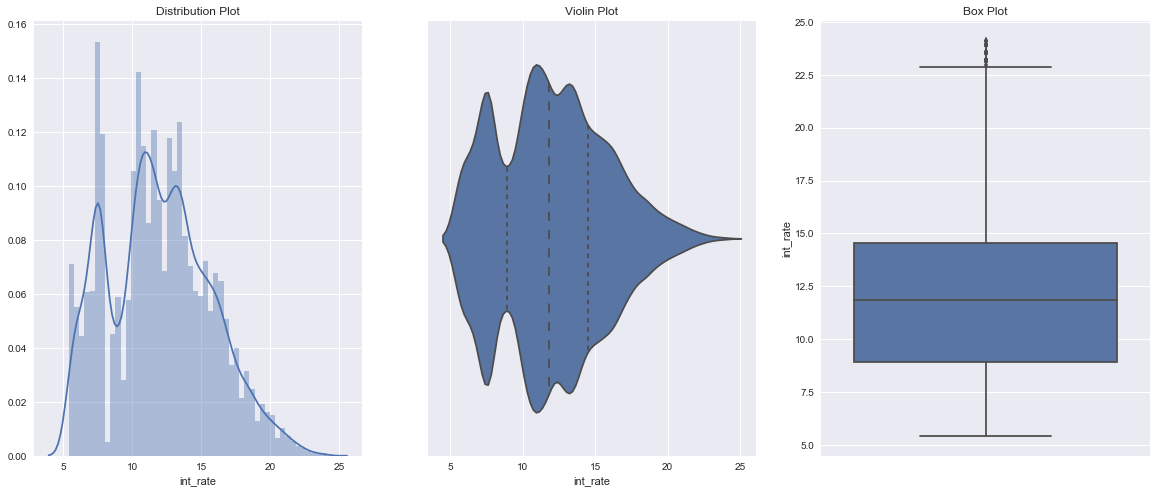

In [29]:
univariate(df=loan,col='int_rate',vartype=0)

<font color='blue'><b>Insights</b>: Most of the loans interest rates are distributed between 8% to 16%.</font> 

#### 3. Annual Income

In [30]:
loan["annual_inc"].describe()

count     32967.00
mean      69739.45
std       66058.85
min        4080.00
25%       42000.00
50%       60000.00
75%       83165.00
max     6000000.00
Name: annual_inc, dtype: float64

###### Max value is 6000000 which is 100 times more than mean value, so we will remove the outliers from Annual Income.

Remove Outliers (values from 98 to 100%)

In [31]:
q = loan["annual_inc"].quantile(0.98)
loan = loan[loan["annual_inc"] < q]

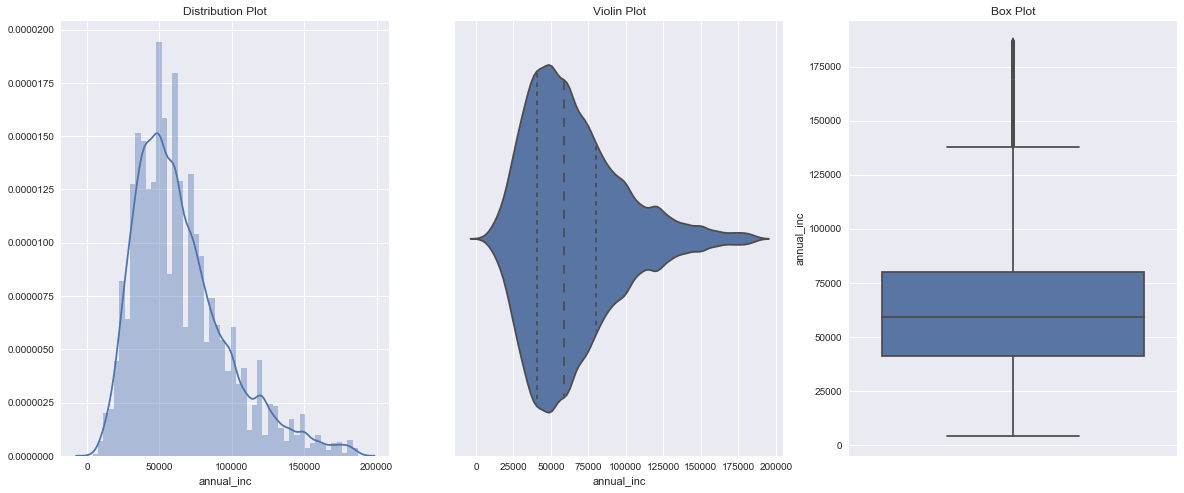

In [32]:
univariate(df=loan,col='annual_inc',vartype=0)

<font color='blue'><b>Insights</b>: Most of the applicants earns beteen 25000 to 80000 USD annually.</font> 

#### 4. DTI

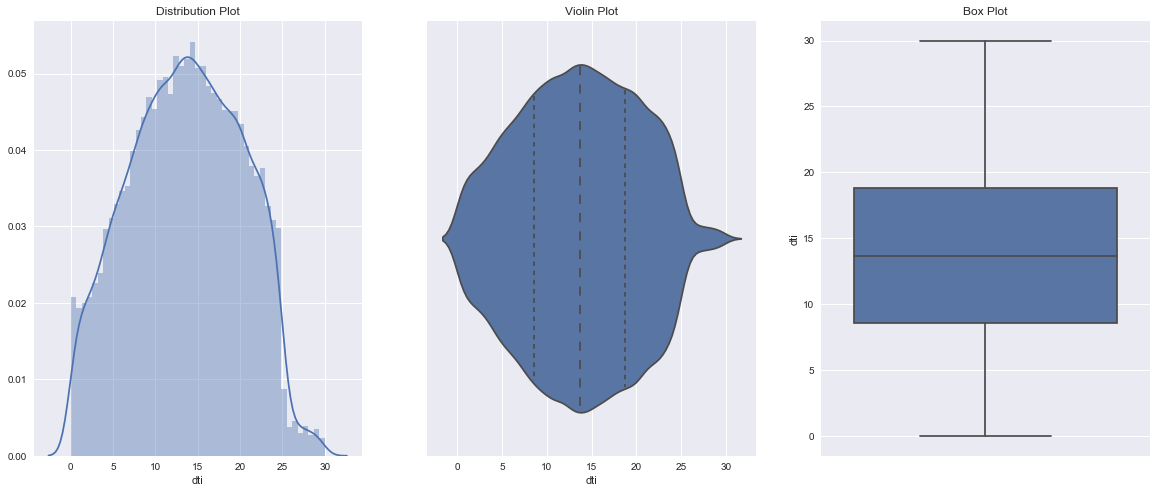

In [33]:
univariate(df=loan,col='dti',vartype=0)

<font color='blue'><b>Insights</b>: Most of the applicants earns beteen 25000 to 80000 USD annually.</font> 

### Categorical Variables

#### 4. Loan Status

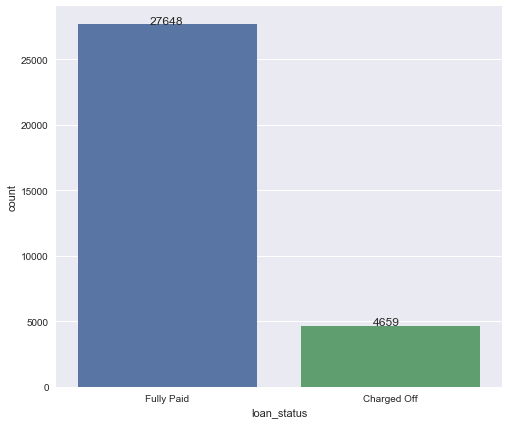

In [34]:
univariate(df=loan,col='loan_status',vartype=1)

<font color='blue'><b>Insights</b>: 17.4% of the applicants Charged off.</font> 

#### 5. Purpose of loan

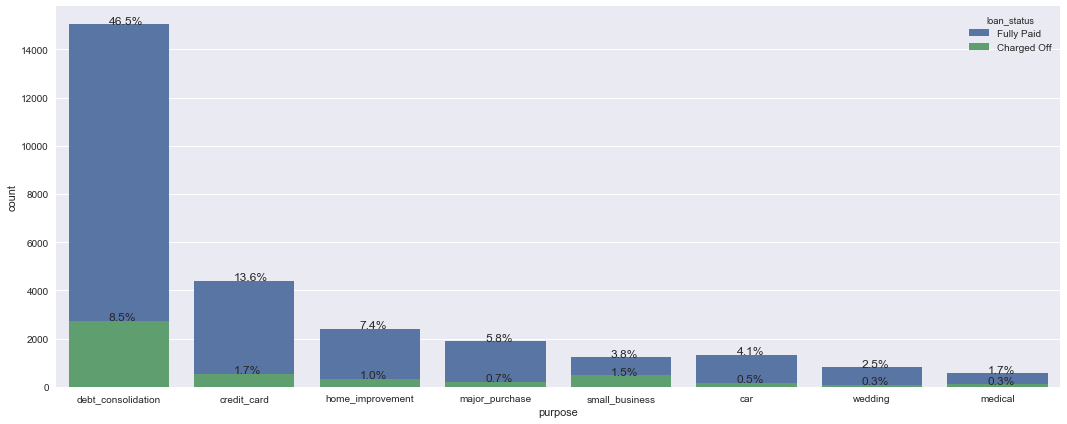

In [35]:
univariate(df=loan,col='purpose',vartype=1,hue='loan_status')

<font color='blue'><b>Insights</b>: Approx 50% of the applicants applied loan for paying their other loans(Debt Consolidation).</font> 

#### 6. Home Ownership wise Loan

In [36]:
loan.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

In [37]:
# Remove rows where home_ownership'=='NONE' (only 1 record)
loan.drop(loan[loan['home_ownership']=='NONE'].index,inplace=True)
loan.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

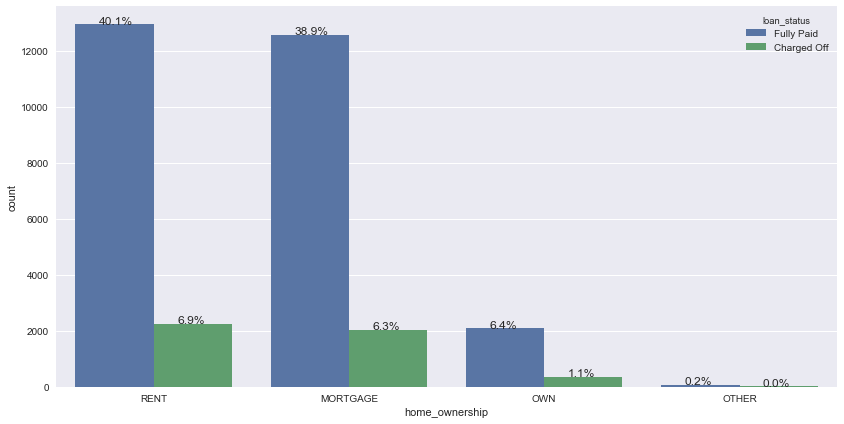

In [38]:
univariate(df=loan,col='home_ownership',vartype=1,hue='loan_status')

<font color='blue'><b>Insights</b>: 47% of applicants are living in rented home whereas 46% applicants were mortagaged their home.</font> 

#### 7. Year wise Loan

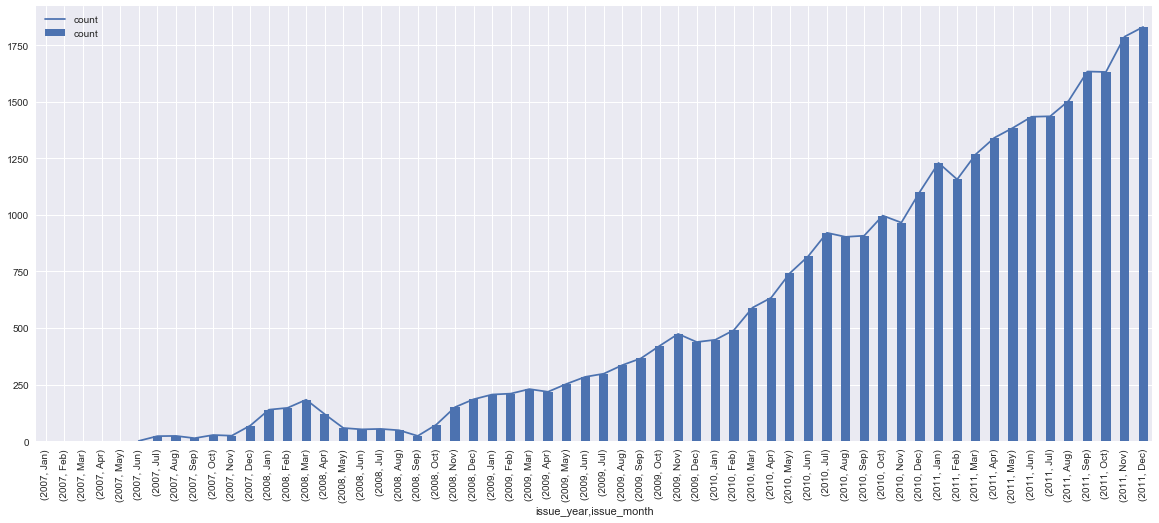

In [39]:
year_wise =loan.groupby(by= [loan.issue_year,loan.issue_month])[['loan_status']].count()
year_wise.rename(columns={"loan_status": "count"},inplace=True)
ax =year_wise.plot(figsize=(20,8))
year_wise.plot(kind='bar',figsize=(20,8),ax = ax)
plt.show()


<font color='blue'><b>Insights</b>: loan applicants are increasing year on year, more than 50% of loan applicants received loans in 2011.</font> 

#### 8. Month wise Loan

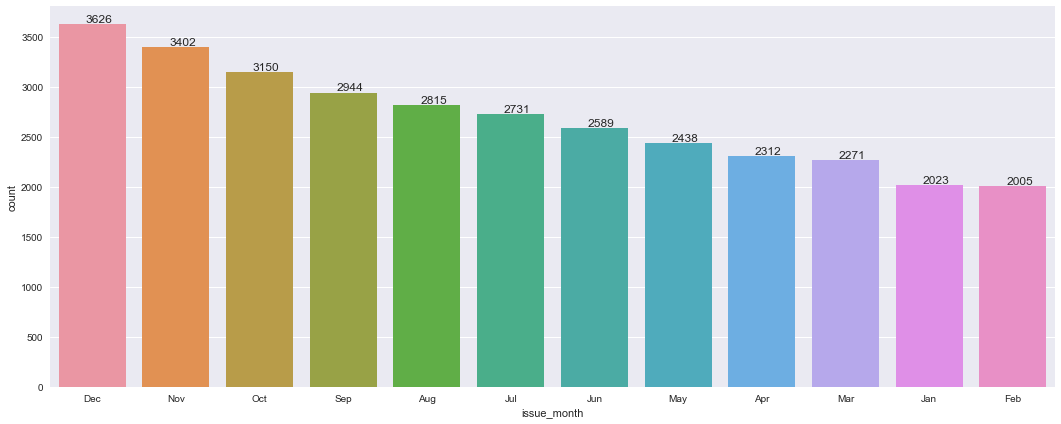

In [40]:
univariate(df=loan,col='issue_month',vartype=1)

<font color='blue'><b>Insights</b>: Loan applicants are more during end of the year.This is may be because of the year end targets</font> 

#### 9. Loan Term

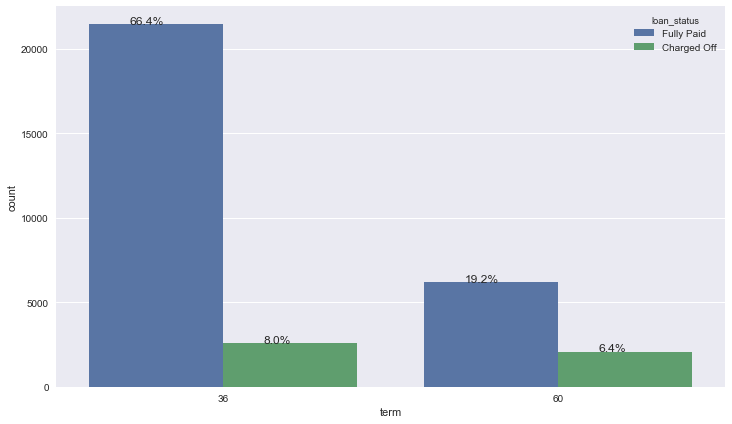

In [41]:
univariate(df=loan,col='term',vartype=1,hue='loan_status')

<font color='blue'><b>Insights</b>: 75% of applicants applied laon for 36 months term period.Applicants who are applied for 60 months term is more probable for charged off</font> 

In [42]:
loan.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,loan_income_ratio,issue_year,issue_month,loan_amnt_range,annual_inc_range,int_rate_range
0,5000,5000,4975.00,36,10.65,162.87,B,B2,NaN,10,RENT,24000.00,Verified,Dec-11,Fully Paid,credit_card,Computer,AZ,27.65,0.21,2011,Dec,0-5000,0-25000,10-12.5
1,2500,2500,2500.00,60,15.27,59.83,C,C4,Ryder,1,RENT,30000.00,Source Verified,Dec-11,Charged Off,car,bike,GA,1.00,0.08,2011,Dec,0-5000,25000-50000,15 and above
2,2400,2400,2400.00,36,15.96,84.33,C,C5,NaN,10,RENT,12252.00,Not Verified,Dec-11,Fully Paid,small_business,real estate business,IL,8.72,0.20,2011,Dec,0-5000,0-25000,15 and above


***
## Bivariate/Multivariate Analysis
Bivariate/Multivariate Analysis finds out the relationship between two/two or more variables.We can perform Bivariate/Multivariate analysis for any combination of categorical and continuous variables. The combination can be: Categorical & Categorical, Categorical & Continuous and Continuous & Continuous.

#### 1. Purpose of Loan vs Loan to Income Ratio for each Loan Status

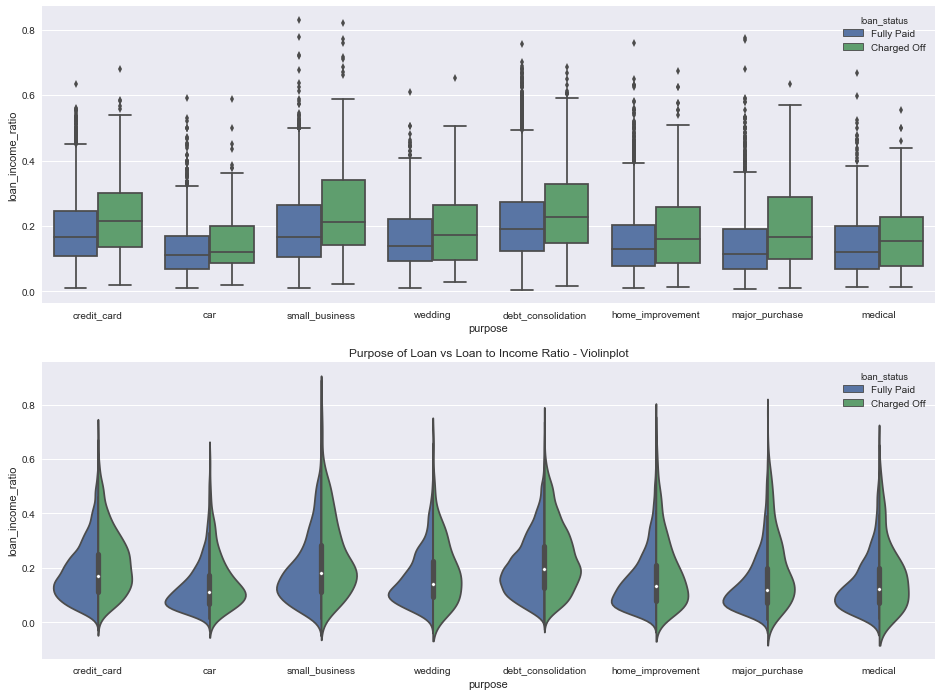

In [43]:
fig, ax=plt.subplots(2,1,figsize=(16,12))
sns.boxplot(data =loan, x='purpose', y='loan_income_ratio', hue ='loan_status',ax=ax[0])
sns.violinplot(data =loan, x='purpose', y='loan_income_ratio', hue ='loan_status', split=True,ax=ax[1])
plt.title('Purpose of Loan vs Loan to Income Ratio - Violinplot')
plt.show()

<font color='blue'><b>Insights</b>: It is clear from above plot that if Loan amount to Income ratio is low it is more likely that the customer will not Charged off.</font>   

#### 2. Correlation Matrix : All Continuos(Numeric) Variables

In [44]:
loan_correlation = loan.corr()
loan_correlation

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,loan_income_ratio
loan_amnt,1.00,0.98,0.94,0.35,0.31,0.93,0.16,0.41,0.08,0.63
funded_amnt,0.98,1.00,0.95,0.33,0.32,0.95,0.16,0.41,0.08,0.62
funded_amnt_inv,0.94,0.95,1.00,0.35,0.31,0.90,0.16,0.39,0.09,0.59
term,0.35,0.33,0.35,1.00,0.44,0.08,0.11,0.07,0.08,0.29
int_rate,0.31,0.32,0.31,0.44,1.00,0.29,0.02,0.07,0.12,0.23
installment,0.93,0.95,0.90,0.08,0.29,1.00,0.13,0.41,0.07,0.57
emp_length,0.16,0.16,0.16,0.11,0.02,0.13,1.00,0.19,0.05,-0.01
annual_inc,0.41,0.41,0.39,0.07,0.07,0.41,0.19,1.00,-0.11,-0.32
dti,0.08,0.08,0.09,0.08,0.12,0.07,0.05,-0.11,1.00,0.15
loan_income_ratio,0.63,0.62,0.59,0.29,0.23,0.57,-0.01,-0.32,0.15,1.00


#### 2. Histogram: All continuos variables

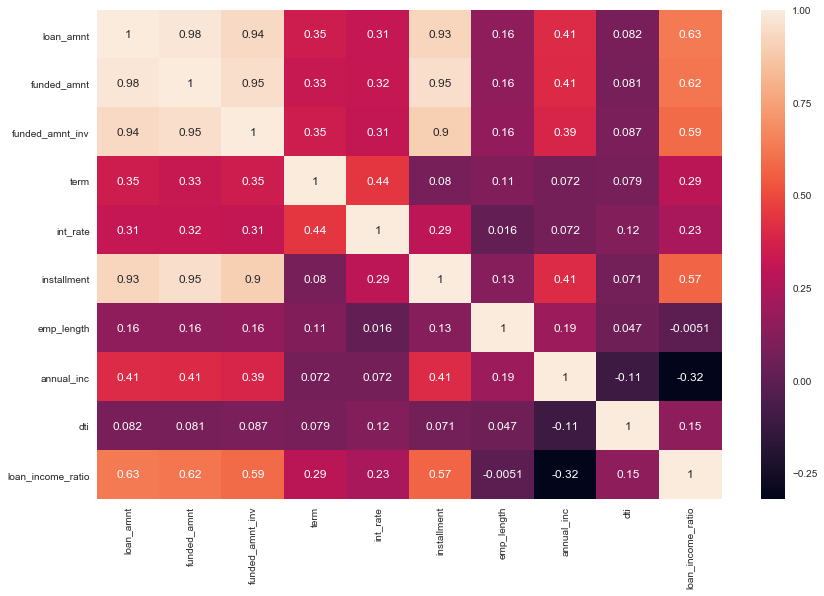

In [45]:
f, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= True)
plt.show()

#### 3. Loan Amount/Annual Income vs Interest Rate

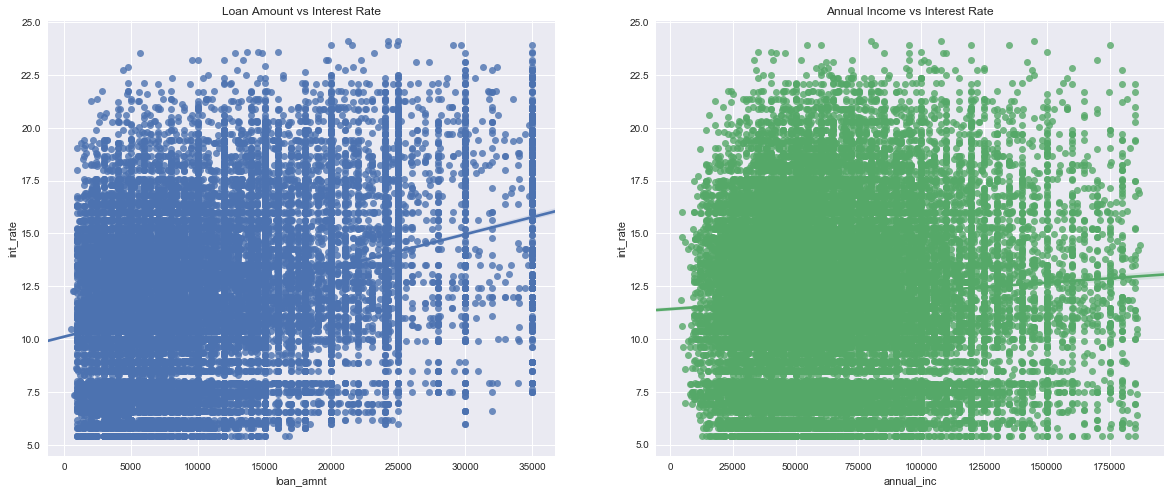

In [46]:
fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,8))
ax[0].set_title("Loan Amount vs Interest Rate")
sns.regplot(data=loan,x= 'loan_amnt', y='int_rate',ax=ax[0])
ax[1].set_title("Annual Income vs Interest Rate")
sns.regplot(data=loan,x= 'annual_inc', y='int_rate',ax=ax[1])
plt.show()

***
### Categorical Variables vs Probability of Charged Off

The main motive of this use case to find what parameters are impacting the most on Loan Status that is if a applicant will successfully complete the loan term or will charge off.

So we will be using a new term now <b>Probability of Charged Off</b> that will be equal to :

\begin{equation*}
{Probability of Charged Off = }\frac{Number of Applicants who has charged off}{Total No. of Applicants}
\end{equation*}


We will calculate this probability w.r.t each column in bivariate analysis & will see how the Probability of Charged Off changes with these columns.

We will create a user defined function for this.

__<font color='green'><u><b>UDF: </b>crosstab</u></font>__
##### 'crosstab' function will be used to get the summarized table for each column(passed as a variable) along with probability of charge off w.r.t that column.

In [47]:
def crosstab(df,col):
    '''
    df : Dataframe
    col: Column Name
    '''
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Charged Off'] = round((crosstab['Charged Off']/crosstab['All']),3)
    crosstab = crosstab[0:-1]
    return crosstab

__<font color='green'><u><b>UDF: </b>bivariate_prob</u></font>__
##### 'bivariate_prob' function will be used to plot count of values for each column(passed as a variable) stacked across 'loan_status' along with probability of charged off as a line chart.

In [48]:
# Probability of charge off
def bivariate_prob(df,col,stacked= True):
    '''
    df      : Dataframe
    col     : Column Name
    stacked : True(default) for Stacked Bar
    '''
    # get dataframe from crosstab function
    plotCrosstab = crosstab(df,col)
    
    linePlot = plotCrosstab[['Probability_Charged Off']]      
    barPlot =  plotCrosstab.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'b')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(),fontsize=14)
    ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
    plt.show()

#### 3. Location vs Probability Charge Off

loan_status,Charged Off,Fully Paid,All,Probability_Charged Off
addr_state,,,,
AK,13,56,69,0.19
AL,47,334,381,0.12
AR,19,183,202,0.09
AZ,100,604,704,0.14
CA,929,4897,5826,0.16


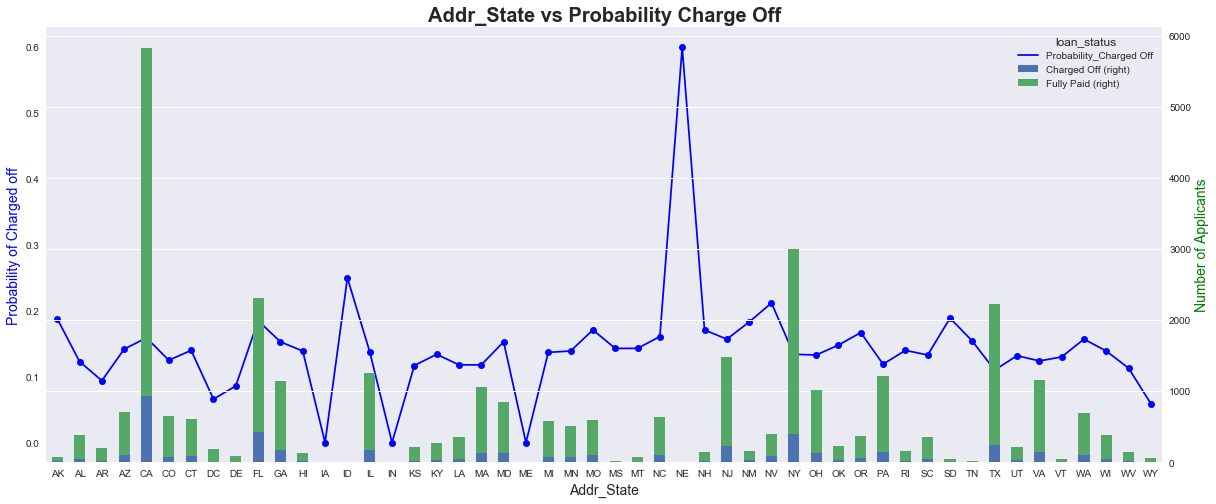

In [49]:
addr_state = crosstab(loan,col ='addr_state')
display(addr_state.head())

bivariate_prob(df =loan,col ='addr_state')

#### 3. Purpose of Loan vs Probability Charge Off

loan_status,Charged Off,Fully Paid,All,Probability_Charged Off
purpose,,,,
car,160,1319,1479,0.11
credit_card,534,4404,4938,0.11
debt_consolidation,2742,15035,17777,0.15
home_improvement,335,2405,2740,0.12
major_purchase,219,1887,2106,0.10
medical,106,555,661,0.16
small_business,469,1227,1696,0.28
wedding,94,815,909,0.10


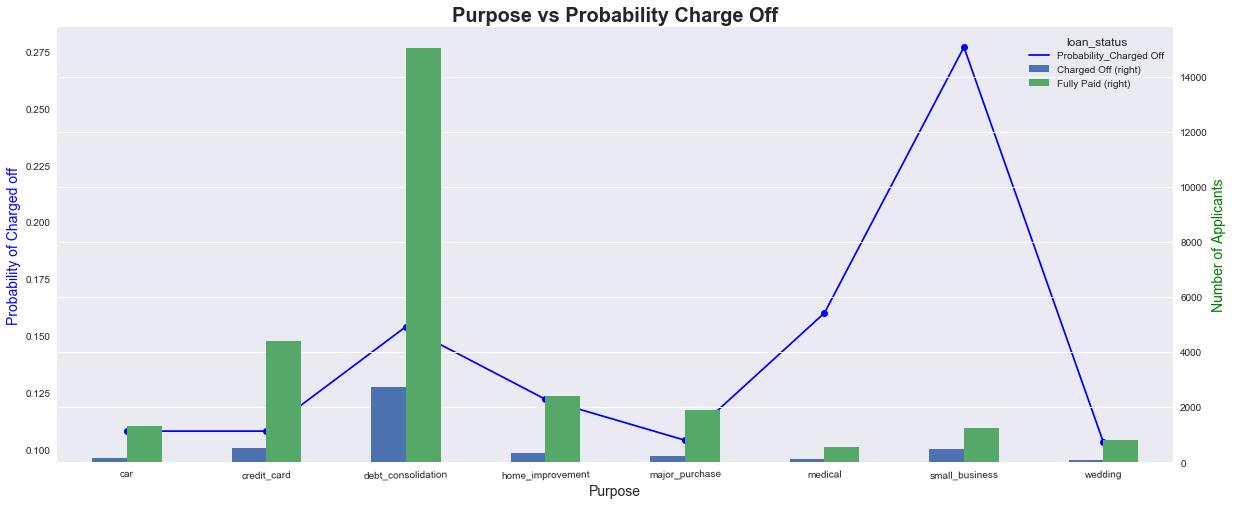

In [50]:
purpose = crosstab(loan,'purpose')
display(purpose)

bivariate_prob(df =loan,col ='purpose',stacked=False)

#### 4. Grade/Subgrade vs Probability Charge Off

loan_status,Charged Off,Fully Paid,All,Probability_Charged Off
grade,,,,
A,474,7856,8330,0.06
B,1153,8613,9766,0.12
C,1114,5394,6508,0.17
D,949,3377,4326,0.22
E,605,1683,2288,0.26
F,279,554,833,0.34
G,85,170,255,0.33


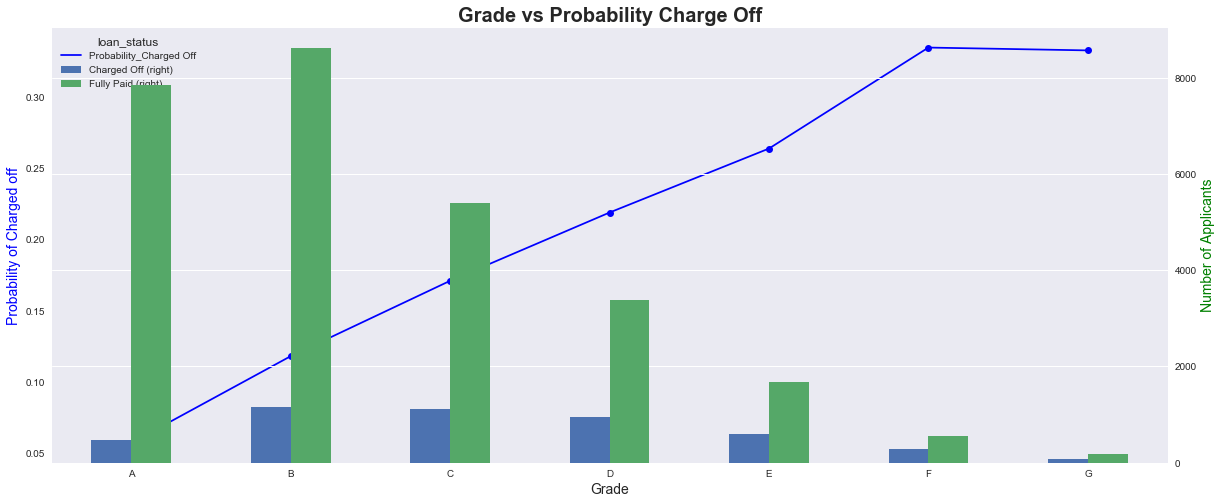

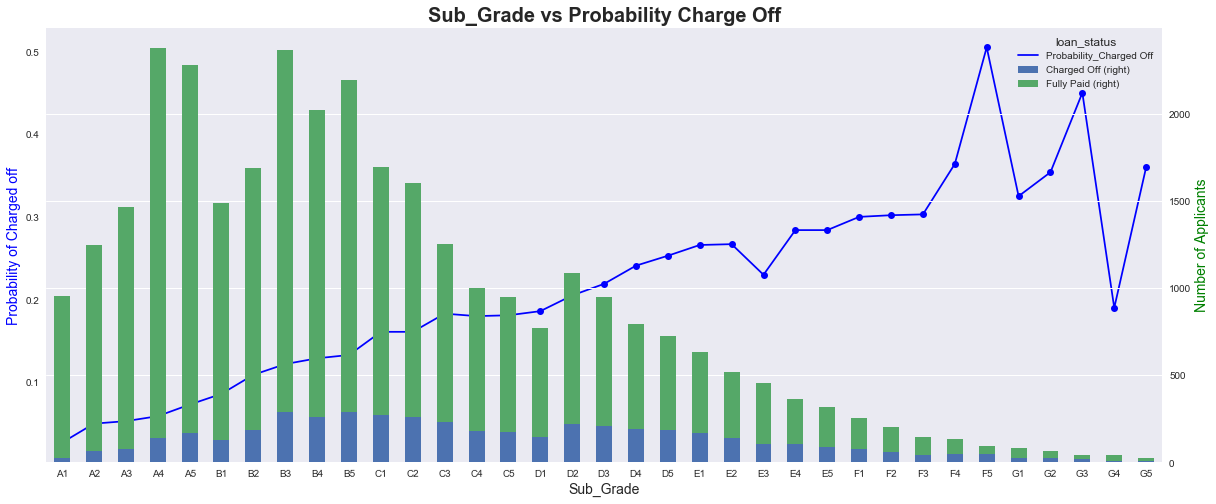

In [51]:
grade = crosstab(loan,'grade')
display(grade)

bivariate_prob(df =loan,col ='grade',stacked=False)
bivariate_prob(df =loan,col ='sub_grade')

#### 5. Month vs Probability Charge Off

loan_status,Charged Off,Fully Paid,All,Probability_Charged Off
issue_month,,,,
Jan,279,1744,2023,0.14
Feb,247,1758,2005,0.12
Mar,298,1973,2271,0.13
Apr,297,2015,2312,0.13
May,378,2060,2438,0.15
Jun,379,2210,2589,0.15
Jul,383,2348,2731,0.14
Aug,391,2424,2815,0.14
Sep,467,2477,2944,0.16


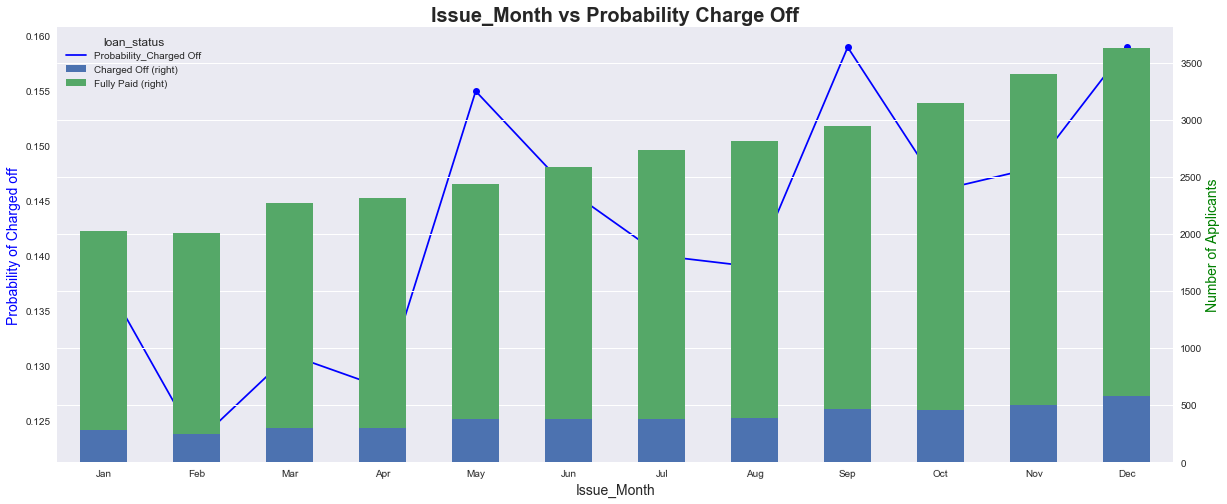

In [52]:
month_wise = crosstab(df =loan,col ='issue_month')
display(month_wise)

bivariate_prob(df =loan,col ='issue_month')

#### 6. Annual Income Range vs Probability Charge Off

loan_status,Charged Off,Fully Paid,All,Probability_Charged Off
annual_inc_range,,,,
0-25000,349,1535,1884,0.18
25000-50000,1754,9073,10827,0.16
50000-75000,1474,8692,10166,0.14
75000-100000,646,4650,5296,0.12
100000 and above,436,3697,4133,0.10


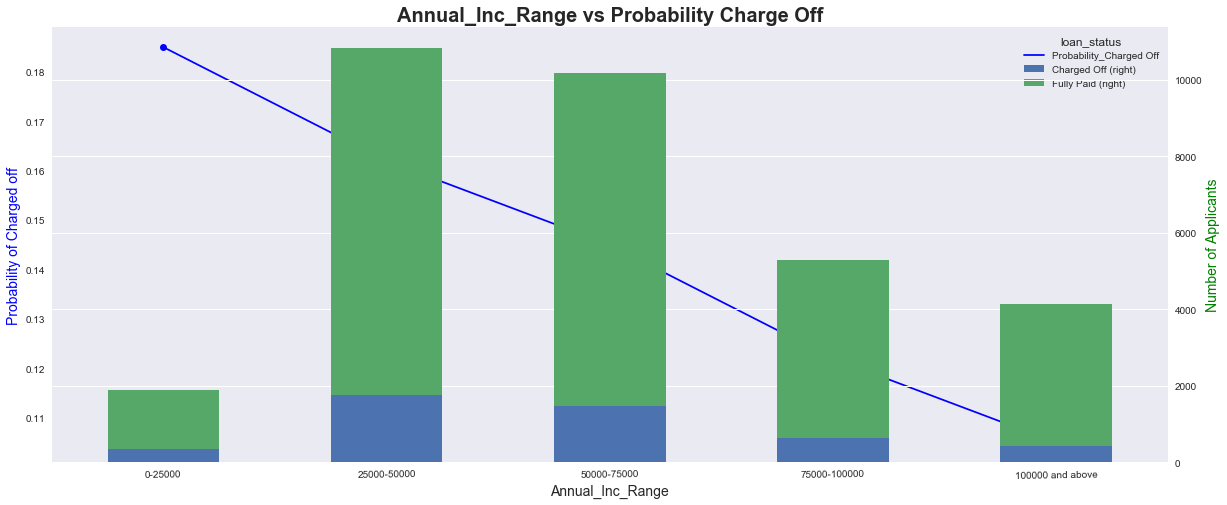

In [53]:
annual_inc_range = crosstab(loan,'annual_inc_range')
display(annual_inc_range)

bivariate_prob(df =loan,col ='annual_inc_range')

#### 7. Loan Amount Range vs Probability Charge Off

loan_status,Charged Off,Fully Paid,All,Probability_Charged Off
loan_amnt_range,,,,
0-5000,881,5969,6850,0.13
5000-10000,1366,9584,10950,0.12
10000-15000,960,5937,6897,0.14
15000-20000,686,3259,3945,0.17
20000-25000,480,1981,2461,0.20
25000 and above,286,917,1203,0.24


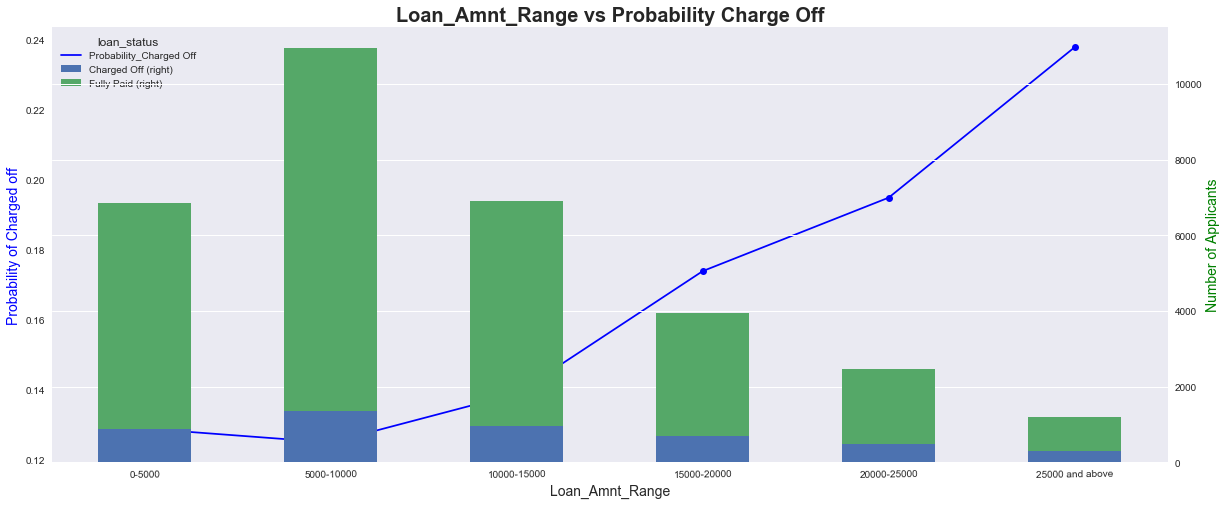

In [54]:
loan_amnt_range = crosstab(loan,'loan_amnt_range')
display(loan_amnt_range)

bivariate_prob(df =loan,col ='loan_amnt_range')

#### 8. Interest rate Range vs Probability Charge Off

loan_status,Charged Off,Fully Paid,All,Probability_Charged Off
int_rate_range,,,,
0-7.5,210,4323,4533,0.05
7.5-10,432,5295,5727,0.07
10-12.5,1020,6793,7813,0.13
12.5-15,1222,6177,7399,0.17
15 and above,1517,4659,6176,0.25


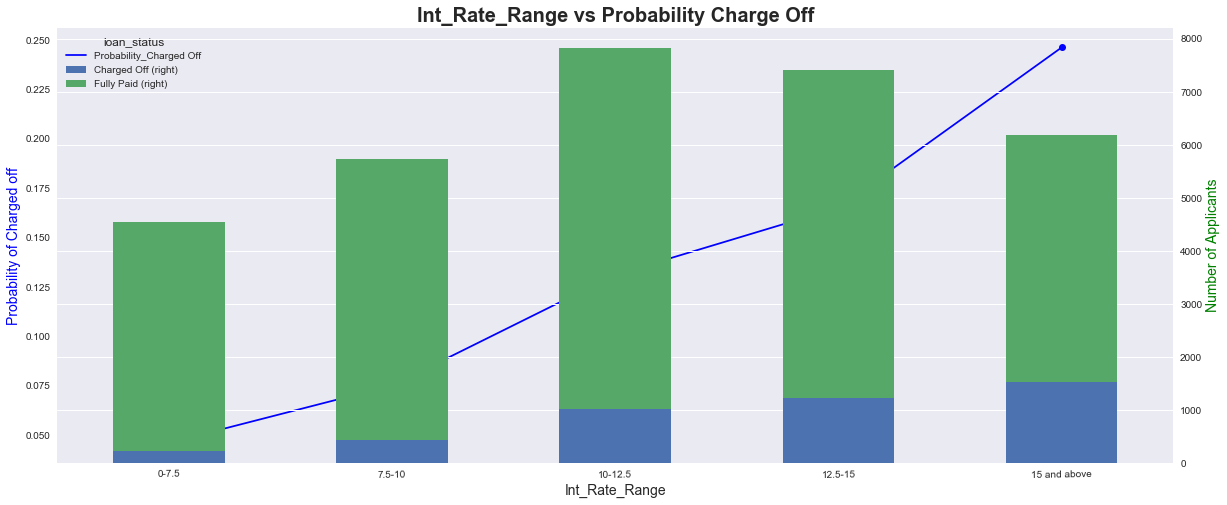

In [55]:
int_rate_range = crosstab(loan,'int_rate_range')
display(int_rate_range)

bivariate_prob(df =loan,col ='int_rate_range')

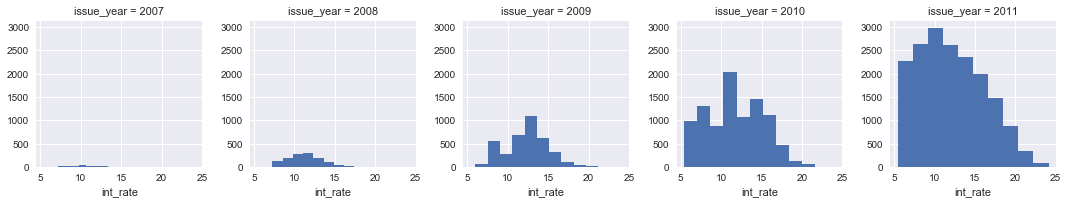

In [56]:
g = sns.FacetGrid(loan, col="issue_year")
g = g.map(plt.hist, "int_rate")

#### 5. Home Ownership vs Probability Charge Off

#### 3.Grade vs Loan status
Categorical vs Categorical

In [57]:
grade_status_compare = pd.crosstab(loan.grade, loan.loan_status,margins=True)
grade_status_compare['Probability_Charged Off'] = round((grade_status_compare['Charged Off']/grade_status_compare['All']),3)
grade_status_compare = (grade_status_compare.iloc[:,[1,0,3]])[0:-1]

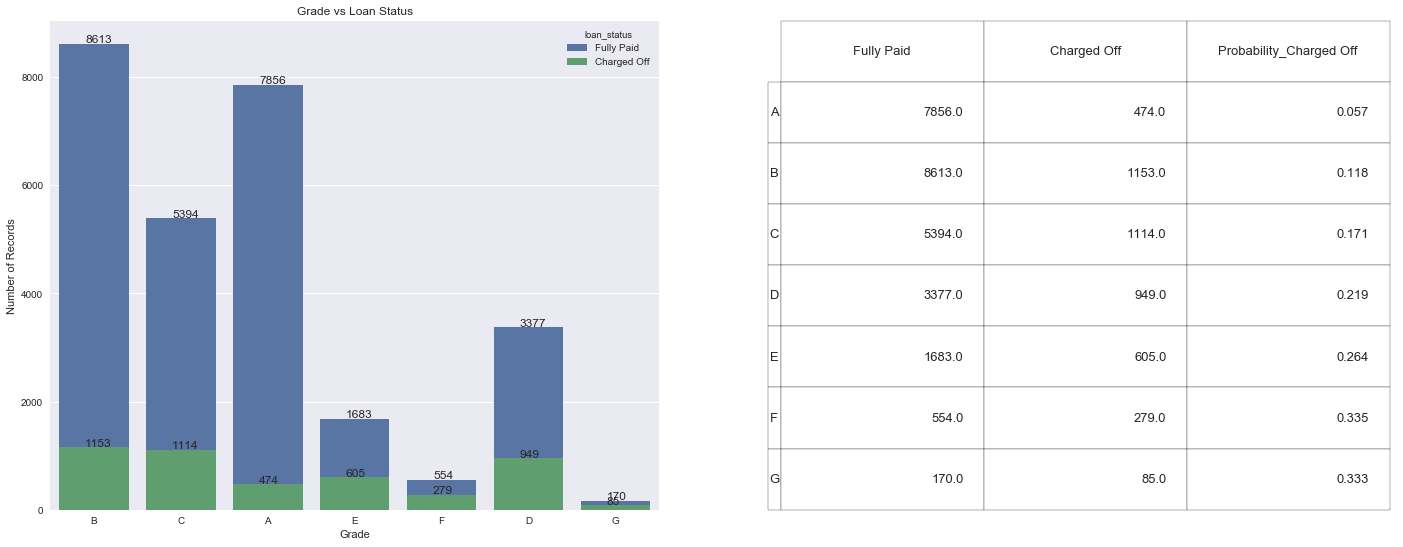

In [58]:
plt.figure(figsize=(24,9))
ax = plt.subplot(121)
ax = sns.countplot(x=loan['grade'], hue = loan['loan_status'], dodge=False)
plt.title('Grade vs Loan Status')
plt.xlabel('Grade')
plt.ylabel('Number of Records')
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+20))
        
ax2 = plt.subplot(122)
font_size=13
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = grade_status_compare.values, rowLabels = grade_status_compare.index, bbox=bbox, \
                      colLabels=grade_status_compare.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)  
plt.show()  

<font color='blue'><b>Insights</b>: As we move from Grade A to G, probability that person will charged off is increasing.So bank should take extra caution while approving the loan for lower grade(E,F,G) applicants.</font>      

 #### 4. Employment Length vs Probability Charged Off

In [59]:
emp_length = pd.crosstab(loan.emp_length, loan.loan_status,margins=True)
emp_length['Probability_Charged Off'] = round((emp_length['Charged Off']/emp_length['All']['All']),3)
emp_length = (emp_length.iloc[:,[1,0,3]])[0:-1]

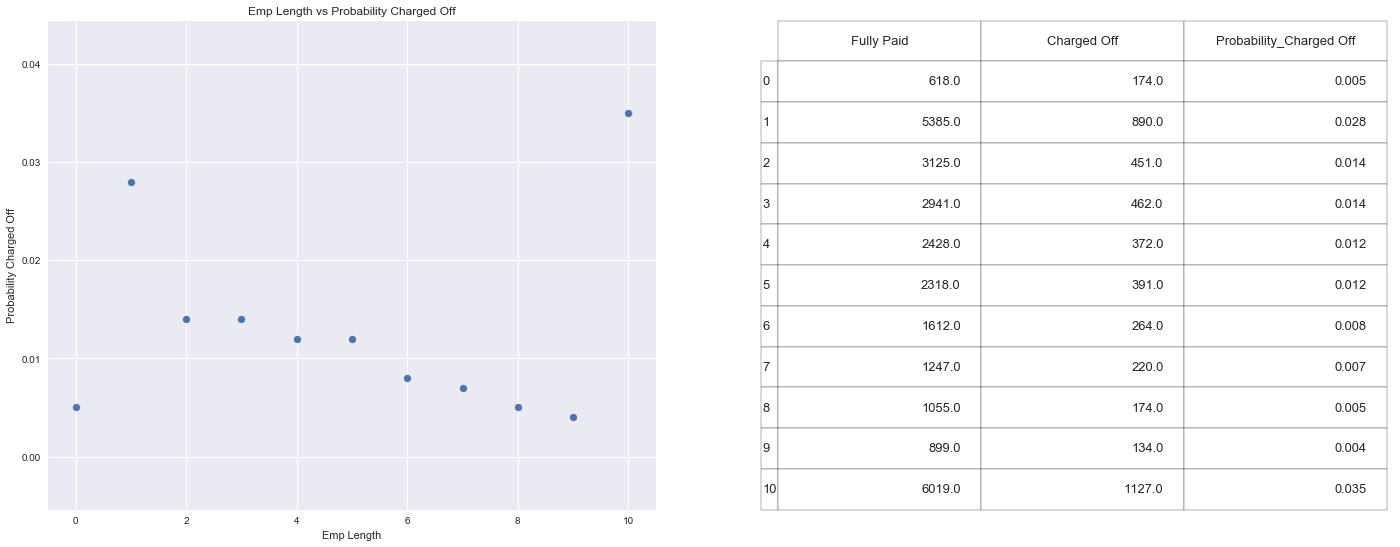

In [60]:
plt.figure(figsize=(24,9))
ax = plt.subplot(121)
ax = plt.scatter(x= emp_length.index, y =emp_length['Probability_Charged Off'])
plt.title('Emp Length vs Probability Charged Off')
plt.xlabel('Emp Length')
plt.ylabel('Probability Charged Off')
        
ax2 = plt.subplot(122)
font_size=13
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = emp_length.values, rowLabels = emp_length.index, bbox=bbox, \
                      colLabels=emp_length.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)  
plt.show()  

<font color='blue'><b>Insights</b>: Employees whose experience is between 2 to 9 years are safe bet for the bank.</font>   

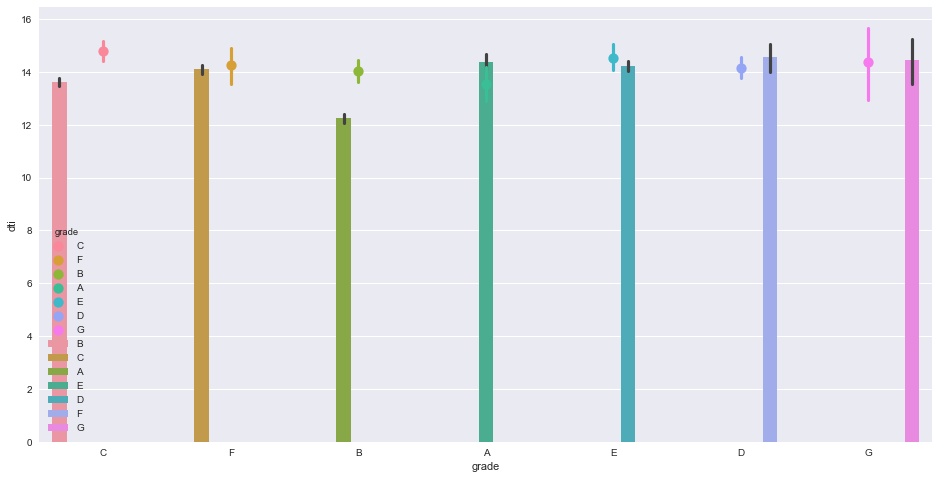

In [61]:
fig, ax=plt.subplots(figsize=(16,8))
sns.barplot(data =loan[loan['loan_status']=='Fully Paid'], x='grade', y='dti', hue ='grade')
sns.pointplot(data =loan[loan['loan_status']=='Charged Off'], x='grade', y='dti', hue ='grade')
plt.show()

 #### 3. Location wise Loans

In [62]:
#fig, ax = plt.subplots()
#fig.set_size_inches(20, 8)
#ax = sns.countplot(x= loan.addr_state)      
#for p in ax.patches:
#        ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.35, p.get_height()+20))  

#### 4. Year wise Loans

In [63]:
#g = sns.FacetGrid(loan, col="issue_year")
#g = g.map(sns.pointplot, "issue_month", "emp_length")
#g.set(xlabel = 'Month', ylabel = '')
#a = sns.FacetGrid(loan, col="issue_year")
#a = a.map(sns.countplot(loan.issue_month))

#### 5. Month wise Loans